<center><p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<center><h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# <center>Домашнее задание. CycleGAN Pytorch

Выполнил: Дмитрий Шерешевский, ID 36196483
(Dmitry Shereshevskiy)

### Введение
Архитектуры подробно изложены в https://arxiv.org/pdf/1703.10593.pdf (1) и https://arxiv.org/pdf/1603.08155.pdf (2). Реализованная здесь архитектура полностью соответствует описаниям в статьях.    
Для дискриминатора использована упомянутая в статьях архтектура Markovian discriminator (PatchGAN). Его идею можно посмотреть, в частности, [здесь](https://www.researchgate.net/figure/The-patchGAN-discriminator-input-of-discriminator-is-either-the-pair-of-sketch-yellow_fig2_325291567).    
Было изучено несколько реализаций CycleGAN, в том числе и на соответствие принципам, изложенным в исходниках (1) и (2). Некоторые идеи для реализации отдельных частей архитектур, которые показались удачными и соответствующими исходным статьям, взяты отсюда https://github.com/aitorzip/PyTorch-CycleGAN, дабы не изобретать всипелосипед. Код адаптирован, значительно переработан и дополнен. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
os.chdir("gdrive/MyDrive/Colab Notebooks/DLSchool_mipt_1sem/cycleGAN_horse/")

## Для начала скачаем датасет.   
Для этой работы взят датасет из репозитория **UC Berkeley**:    
https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/


#### Имена датасетов в репозитории:    
apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos


### download dataset

In [3]:
dataset_name = "horse2zebra"

Для скачивания датасета необходимо раскоментить следующую ячейку при первом прохождении ноутбука.   
В настоящий момент ячейка закоментина, чтобы не скачивать при отладке одни и те же файлы.

In [4]:
# URL = f"https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{dataset_name}.zip"
# if not os.path.exists('datasets'):
#     os.mkdir('datasets')
# ZIP_FILE = f"./datasets/{dataset_name}.zip"
# TARGET_DIR = f"./datasets/{dataset_name}"
# ! mkdir -p ./datasets
# ! wget -N $URL -O $ZIP_FILE
# ! unzip $ZIP_FILE -d ./datasets/
# ! rm $ZIP_FILE

In [5]:
import glob
import random
import os

from torch.utils.data import Dataset, DataLoader, RandomSampler
from PIL import Image
import torchvision.transforms as transforms
import torch
import sys
import numpy as np
from torchvision.utils import save_image

import matplotlib.pyplot as plt

import itertools
import json

## класс для Dataset

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode

        self.files_A = sorted(glob.glob(os.path.join(root, f'{mode}A', '*.*')))
        self.files_B = sorted(glob.glob(os.path.join(root, f'{mode}B', '*.*')))
    
    def to3channs(self, image):
        num_channels = len(image.split())
        if num_channels == 1:
            image = Image.merge("RGB", [image] * 3)
        return image
    
    def __getitem__(self, index):
        image = self.to3channs(Image.open(self.files_A[index % len(self.files_A)]))
        item_A = self.transform(image)

        if self.mode == "train":
            if self.unaligned:
                image = self.to3channs(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
                item_B = self.transform(image)
            else:
                image = self.to3channs(Image.open(self.files_B[index % len(self.files_B)]))
                item_B = self.transform(image)
        
        elif self.mode == "test":
            image = self.to3channs(Image.open(self.files_B[index % len(self.files_B)]))
            item_B = self.transform(image)
        
        else:
            raise ValueError("The parameter 'mode' should only be 'train' or 'test'.")

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

### посмотрим на некоторые изображения тестового датасета

In [7]:
test_transforms = [transforms.ToTensor(),
                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
test_dataset = ImageDataset(f"datasets/{dataset_name}", test_transforms, mode="test")

In [8]:
def plot_dataset(dataset, inds=tuple(range(6))):
    plt.figure(figsize=(18, 6))
    for i in inds:
        plt.subplot(2, len(inds), i+1)
        plt.axis("off")
        plt.imshow(0.5 * (test_dataset[i]["A"].numpy().transpose((1, 2, 0)) + 1))
        plt.title("real_A")

        plt.subplot(2, len(inds), i+7)
        plt.axis("off")
        plt.imshow(0.5 * (test_dataset[i]["B"].numpy().transpose((1, 2, 0)) + 1))
        plt.title("real_B")
    plt.show()

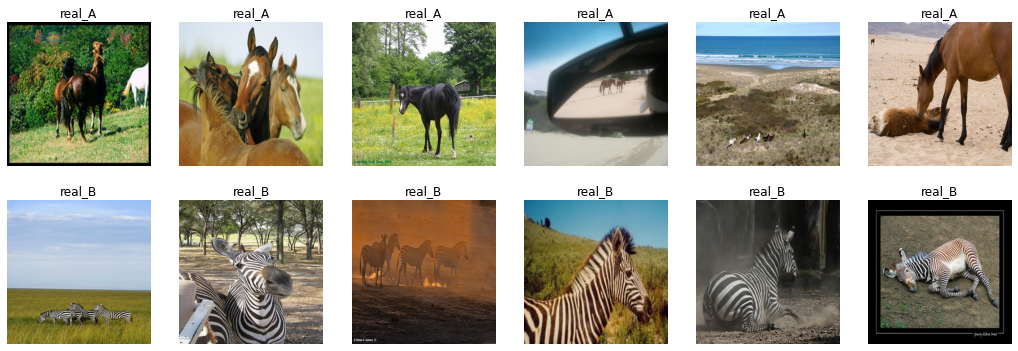

In [9]:
plot_dataset(test_dataset)

### Модели

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3), 
                      nn.InstanceNorm2d(in_features),
                      nn.ReLU(inplace=True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super().__init__()

        # Initial convolution block       
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]

            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# for discriminator was used Markovian discriminator (PatchGAN) with the average pooling as output 
class PatchlBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        conv_block = [nn.Conv2d(in_features, out_features, 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features), 
                      nn.LeakyReLU(0.2, inplace=True)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        model = []
        model += [PatchlBlock(input_nc, 64), 
                  PatchlBlock(64, 128), 
                  PatchlBlock(128, 256), 
                  PatchlBlock(256, 512)]
        # to one channel for the next average pooling
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.shape[2:]).view(x.shape[0], -1)

In [11]:
class ImageBuffer:
    def __init__(self, max_size=50):
        if max_size < 0:
            print('Warning: Empty buffer or trying to create a black hole. Be careful.')
        self.max_size = max_size
        self.data = []

    def update(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

class LambdaLR:
    def __init__(self, n_epochs, offset=0, decay_start_epoch=100):
        if (n_epochs - decay_start_epoch) < 0:
            print("Warning: Decay must start before the training session ends!")
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

#### функция для отрисовки тестовых картинок при обучении

In [12]:
def plot_images(images: dict):
    img_len = len(images)
    fig, axes = plt.subplots(ncols=img_len, figsize=(9, img_len))
    for i, img_name in enumerate(images):
        ax = axes[i]
        ax.axis("off")
        img = 0.5 * (images[img_name].cpu().squeeze(0).detach().numpy().transpose((1, 2, 0)) + 1)
        ax.imshow(img)
        ax.set_title(img_name)
    plt.show()

## Функции **train** и **test** - обучение и тестирование во время обучения

In [13]:
def train(netG_A2B, netG_B2A, netD_A, netD_B, dataloader, epoch, plot_images_=False, plot_img_step=10, log=None):
    mode = "TRAIN"
    epoch_log = {}
    lambda_ = 10
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)

        # Total loss
        loss_G = 0.5*lambda_ * (loss_identity_A + loss_identity_B) + \
                 loss_GAN_A2B + loss_GAN_B2A + \
                 lambda_ * (loss_cycle_ABA + loss_cycle_BAB)
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.update(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake) / 2
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.update(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) / 2
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # epoch_log
        epoch_log["loss_G"] = epoch_log.get("loss_G", 0) + loss_G.item()
        epoch_log["loss_G_identity"] = epoch_log.get("loss_G_identity", 0) + (loss_identity_A + loss_identity_B).item()
        epoch_log["loss_G_GAN"] = epoch_log.get("loss_G_GAN", 0) + (loss_GAN_A2B + loss_GAN_B2A).item()
        epoch_log["loss_G_cycle"] = epoch_log.get("loss_G_cycle", 0) + (loss_cycle_ABA + loss_cycle_BAB).item()
        epoch_log["loss_D"] = epoch_log.get("loss_D", 0) + (loss_D_A + loss_D_B).item()
    
        if i == 0 and epoch == 0:
            print("Init images")
            images={'real_A': real_A, 'fake_B': fake_B, 'real_B': real_B, 'fake_A': fake_A}
            plot_images(images)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()  

    # logs update
    for loss_item in log:
        epoch_log[loss_item] /= len(dataloader)
        log[loss_item].append(epoch_log[loss_item])
    
    # log print
    loss_line = ", ".join([f"{loss_item}: {epoch_log[loss_item]:.4f}" for loss_item in epoch_log])
    log_line = f"{mode} - {loss_line}"
    print(log_line)
    if plot_images_:
        if (epoch + 1) % plot_img_step == 0:
            images={'real_A': real_A, 'fake_B': fake_B, 'real_B': real_B, 'fake_A': fake_A}
            plot_images(images)
    
    # Save models checkpoints and log
    if not os.path.exists('output'):
        os.mkdir('output')


    torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(netD_B.state_dict(), 'output/netD_B.pth')

    with open("output/train_log.json", "w") as file:
        json.dump(log, file)

In [14]:
def test(netG_A2B, netG_B2A, netD_A, netD_B, dataloader, epoch, plot_images_=False, plot_img_step=10, log=None):
    mode = "TEST"
    epoch_log = {}
    lambda_ = 10
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        ###### Generators A2B and B2A ######
        with torch.no_grad():
            # Identity loss
            # G_A2B(B) should equal B if real B is fed
            same_B = netG_A2B(real_B)
            loss_identity_B = criterion_identity(same_B, real_B)
            # G_B2A(A) should equal A if real A is fed
            same_A = netG_B2A(real_A)
            loss_identity_A = criterion_identity(same_A, real_A)

            # GAN loss
            fake_B = netG_A2B(real_A)
            pred_fake = netD_B(fake_B)
            loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

            fake_A = netG_B2A(real_B)
            pred_fake = netD_A(fake_A)
            loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

            # Cycle loss
            recovered_A = netG_B2A(fake_B)
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A)

            recovered_B = netG_A2B(fake_A)
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B)

            # Total loss
            loss_G = 0.5*lambda_ * (loss_identity_A + loss_identity_B) + \
                     loss_GAN_A2B + loss_GAN_B2A + \
                     lambda_ * (loss_cycle_ABA + loss_cycle_BAB)
            
            ###################################

            ###### Discriminator A ######

            # Real loss
            pred_real = netD_A(real_A)
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            pred_fake = netD_A(fake_A.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake) / 2

            ###################################

            ###### Discriminator B ######
            # Real loss
            pred_real = netD_B(real_B)
            loss_D_real = criterion_GAN(pred_real, target_real)
            
            # Fake loss
            pred_fake = netD_B(fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake) / 2
            ###################################

            # epoch_log
            epoch_log["loss_G"] = epoch_log.get("loss_G", 0) + loss_G.item()
            epoch_log["loss_G_identity"] = epoch_log.get("loss_G_identity", 0) + (loss_identity_A + loss_identity_B).item()
            epoch_log["loss_G_GAN"] = epoch_log.get("loss_G_GAN", 0) + (loss_GAN_A2B + loss_GAN_B2A).item()
            epoch_log["loss_G_cycle"] = epoch_log.get("loss_G_cycle", 0) + (loss_cycle_ABA + loss_cycle_BAB).item()
            epoch_log["loss_D"] = epoch_log.get("loss_D", 0) + (loss_D_A + loss_D_B).item()

    # logs update
    for loss_item in log:
        epoch_log[loss_item] /= len(dataloader)
        log[loss_item].append(epoch_log[loss_item])
    
    # log print and plot of images
    loss_line = ", ".join([f"{loss_item}: {epoch_log[loss_item]:.4f}" for loss_item in epoch_log])
    log_line = f"{mode} -  {loss_line}"
    print(log_line)
    if plot_images_:
        if (epoch + 1) % plot_img_step == 0:
            images={'real_A': real_A, 'fake_B': fake_B, 'real_B': real_B, 'fake_A': fake_A}
            plot_images(images)

    # Save log and the best G models
    if not os.path.exists('output/best'):
        os.makedirs('output/best')

    with open("output/test_log.json", "w") as file:
        json.dump(log, file)

    if log["loss_G"][-1] <= min(log["loss_G"]):
        torch.save(netG_A2B.state_dict(), 'output/best/netG_A2B.pth')
        torch.save(netG_B2A.state_dict(), 'output/best/netG_B2A.pth')

### инициализация для обучения - параметры, классы моделей и таргеты

In [15]:
# params init
n_epochs = 200  # number of epochs of training
batchSize = 1  # size of the batches
dataroot = f'datasets/{dataset_name}/'  # root directory of the dataset
lr = 0.0002  # initial learning rate
decay_epoch = 100  # epoch to start linearly decaying the learning rate to 0
size = 256  # size of the data crop (squared assumed)
input_nc = 3  # number of channels of input data
output_nc = 3  # number of channels of output data
n_cpu = 8  # number of cpu threads to use during batch generation

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(output_nc).to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, decay_start_epoch=decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, decay_start_epoch=decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, decay_start_epoch=decay_epoch).step)

# Inputs
input_A = torch.Tensor(batchSize, input_nc, size, size).to(device)
input_B = torch.Tensor(batchSize, output_nc, size, size).to(device)

target_real = torch.ones(batchSize, 1, requires_grad=False).to(device)
target_fake = torch.zeros(batchSize, 1, requires_grad=False).to(device)

fake_A_buffer = ImageBuffer()
fake_B_buffer = ImageBuffer()

#### инициализация даталоадеров

In [16]:
# Dataset loaders
num_samples = 300  # приходится ограничивать из-за ограниченных ресурсов колаба, в действительности картинок больше

train_transforms = [transforms.Resize(int(size*1.12),  Image.BICUBIC), 
                    transforms.RandomCrop(size), 
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
train_dataset = ImageDataset(dataroot, transforms_=train_transforms, unaligned=True)
train_sampler = RandomSampler(train_dataset, replacement=True, num_samples=num_samples)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler,
                        batch_size=batchSize, num_workers=n_cpu)

test_transforms = [transforms.ToTensor(),
                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
test_dataloader = DataLoader(ImageDataset(dataroot, transforms_=test_transforms, unaligned=False, mode="test"), 
                        batch_size=batchSize, shuffle=True, num_workers=n_cpu)

## непосредственно обучение
выводим на каждой эпохе информацию о лоссах и текущие тестовые картинки 

In [19]:
def train_loop(from_checkpoint=False):
    start_epoch = 0
    # инициализация loss-логов
    losses = ['loss_G', 'loss_G_identity', 'loss_G_GAN', 'loss_G_cycle', 'loss_D']
    train_log = {loss: [] for loss in losses}
    test_log = {loss: [] for loss in losses}

    if from_checkpoint:
        with open(f"output/train_log.json", "r") as file:
            train_log = json.load(file)
        with open(f"output/test_log.json", "r") as file:
            test_log = json.load(file)
        
        start_epoch = len(train_log["loss_G"])

        # load state dicts
        netG_A2B.load_state_dict(torch.load('output/netG_A2B.pth', map_location=device))
        netG_B2A.load_state_dict(torch.load('output/netG_B2A.pth', map_location=device))
        netD_A.load_state_dict(torch.load('output/netD_A.pth', map_location=device))
        netD_B.load_state_dict(torch.load('output/netD_B.pth', map_location=device))
    
    for epoch in range(start_epoch, n_epochs):
        print(f"Epoch - {epoch+1}")
        netG_A2B.train()
        netG_B2A.train()
        netD_A.train()
        netD_B.train()
        train(netG_A2B, netG_B2A, netD_A, netD_B, train_dataloader, epoch, log=train_log)
        netG_A2B.eval()
        netG_B2A.eval()
        netD_A.eval()
        netD_B.eval()
        test(netG_A2B, netG_B2A, netD_A, netD_B, test_dataloader, epoch, plot_images_=True, log=test_log)

Epoch - 137
TRAIN - loss_G: 3.9998, loss_G_identity: 0.1922, loss_G_GAN: 0.7752, loss_G_cycle: 0.2264, loss_D: 0.3302
TEST -  loss_G: 4.9244, loss_G_identity: 0.2213, loss_G_GAN: 1.1778, loss_G_cycle: 0.2640, loss_D: 0.5237
Epoch - 138
TRAIN - loss_G: 4.2697, loss_G_identity: 0.2004, loss_G_GAN: 0.8981, loss_G_cycle: 0.2369, loss_D: 0.3457
TEST -  loss_G: 4.9058, loss_G_identity: 0.2316, loss_G_GAN: 1.0049, loss_G_cycle: 0.2743, loss_D: 0.3932
Epoch - 139
TRAIN - loss_G: 4.2408, loss_G_identity: 0.2013, loss_G_GAN: 0.8626, loss_G_cycle: 0.2372, loss_D: 0.3478
TEST -  loss_G: 4.3118, loss_G_identity: 0.2211, loss_G_GAN: 0.6159, loss_G_cycle: 0.2590, loss_D: 0.4494
Epoch - 140
TRAIN - loss_G: 4.2293, loss_G_identity: 0.2051, loss_G_GAN: 0.8156, loss_G_cycle: 0.2388, loss_D: 0.3529
TEST -  loss_G: 4.3214, loss_G_identity: 0.2180, loss_G_GAN: 0.6377, loss_G_cycle: 0.2594, loss_D: 0.4401


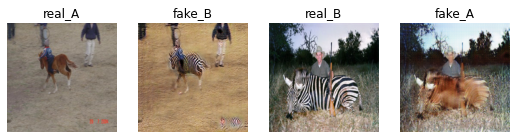

Epoch - 141
TRAIN - loss_G: 4.3160, loss_G_identity: 0.2026, loss_G_GAN: 0.8836, loss_G_cycle: 0.2419, loss_D: 0.3347
TEST -  loss_G: 5.7910, loss_G_identity: 0.2465, loss_G_GAN: 1.2834, loss_G_cycle: 0.3275, loss_D: 0.5129
Epoch - 142
TRAIN - loss_G: 4.3497, loss_G_identity: 0.2068, loss_G_GAN: 0.8642, loss_G_cycle: 0.2452, loss_D: 0.3539
TEST -  loss_G: 4.5573, loss_G_identity: 0.2231, loss_G_GAN: 0.8259, loss_G_cycle: 0.2616, loss_D: 0.5921
Epoch - 143
TRAIN - loss_G: 4.1742, loss_G_identity: 0.1957, loss_G_GAN: 0.8561, loss_G_cycle: 0.2340, loss_D: 0.3633
TEST -  loss_G: 4.4717, loss_G_identity: 0.2284, loss_G_GAN: 0.7067, loss_G_cycle: 0.2623, loss_D: 0.4206
Epoch - 144
TRAIN - loss_G: 4.2909, loss_G_identity: 0.2011, loss_G_GAN: 0.8689, loss_G_cycle: 0.2417, loss_D: 0.3581
TEST -  loss_G: 4.6926, loss_G_identity: 0.2281, loss_G_GAN: 0.8310, loss_G_cycle: 0.2721, loss_D: 0.4208
Epoch - 145
TRAIN - loss_G: 4.2763, loss_G_identity: 0.2048, loss_G_GAN: 0.8413, loss_G_cycle: 0.2411, l

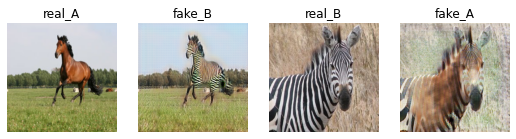

Epoch - 151
TRAIN - loss_G: 4.3844, loss_G_identity: 0.2119, loss_G_GAN: 0.8112, loss_G_cycle: 0.2514, loss_D: 0.3527
TEST -  loss_G: 5.3623, loss_G_identity: 0.2587, loss_G_GAN: 0.7779, loss_G_cycle: 0.3291, loss_D: 0.4069
Epoch - 152
TRAIN - loss_G: 4.3267, loss_G_identity: 0.2043, loss_G_GAN: 0.8626, loss_G_cycle: 0.2443, loss_D: 0.3515
TEST -  loss_G: 4.9225, loss_G_identity: 0.2304, loss_G_GAN: 1.0659, loss_G_cycle: 0.2704, loss_D: 0.5084
Epoch - 153
TRAIN - loss_G: 4.2758, loss_G_identity: 0.2004, loss_G_GAN: 0.8595, loss_G_cycle: 0.2414, loss_D: 0.3657
TEST -  loss_G: 4.5981, loss_G_identity: 0.2334, loss_G_GAN: 0.5910, loss_G_cycle: 0.2840, loss_D: 0.4336
Epoch - 154
TRAIN - loss_G: 4.2382, loss_G_identity: 0.2014, loss_G_GAN: 0.8061, loss_G_cycle: 0.2425, loss_D: 0.3507
TEST -  loss_G: 4.5222, loss_G_identity: 0.2210, loss_G_GAN: 0.6321, loss_G_cycle: 0.2785, loss_D: 0.5289
Epoch - 155
TRAIN - loss_G: 4.2496, loss_G_identity: 0.2013, loss_G_GAN: 0.8484, loss_G_cycle: 0.2395, l

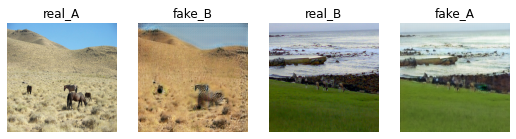

Epoch - 161
TRAIN - loss_G: 4.2352, loss_G_identity: 0.1968, loss_G_GAN: 0.8449, loss_G_cycle: 0.2406, loss_D: 0.3482
TEST -  loss_G: 4.3947, loss_G_identity: 0.2216, loss_G_GAN: 0.6473, loss_G_cycle: 0.2639, loss_D: 0.6322
Epoch - 162
TRAIN - loss_G: 4.2161, loss_G_identity: 0.2018, loss_G_GAN: 0.8143, loss_G_cycle: 0.2393, loss_D: 0.3780
TEST -  loss_G: 5.1367, loss_G_identity: 0.2237, loss_G_GAN: 1.3656, loss_G_cycle: 0.2653, loss_D: 0.3683
Epoch - 163
TRAIN - loss_G: 4.2314, loss_G_identity: 0.1955, loss_G_GAN: 0.9082, loss_G_cycle: 0.2346, loss_D: 0.3321
TEST -  loss_G: 4.8814, loss_G_identity: 0.2252, loss_G_GAN: 1.0572, loss_G_cycle: 0.2698, loss_D: 0.4904
Epoch - 164
TRAIN - loss_G: 4.2311, loss_G_identity: 0.1994, loss_G_GAN: 0.8564, loss_G_cycle: 0.2378, loss_D: 0.3532
TEST -  loss_G: 4.8415, loss_G_identity: 0.2267, loss_G_GAN: 1.0637, loss_G_cycle: 0.2644, loss_D: 0.3954
Epoch - 165
TRAIN - loss_G: 4.3166, loss_G_identity: 0.1972, loss_G_GAN: 0.9417, loss_G_cycle: 0.2389, l

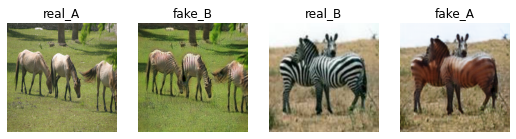

Epoch - 171
TRAIN - loss_G: 4.0767, loss_G_identity: 0.1907, loss_G_GAN: 0.8556, loss_G_cycle: 0.2268, loss_D: 0.3389
TEST -  loss_G: 4.5702, loss_G_identity: 0.2223, loss_G_GAN: 0.8696, loss_G_cycle: 0.2589, loss_D: 0.3732
Epoch - 172
TRAIN - loss_G: 4.2921, loss_G_identity: 0.2018, loss_G_GAN: 0.8591, loss_G_cycle: 0.2424, loss_D: 0.3594
TEST -  loss_G: 4.7761, loss_G_identity: 0.2231, loss_G_GAN: 0.9541, loss_G_cycle: 0.2707, loss_D: 0.5864
Epoch - 173
TRAIN - loss_G: 4.1957, loss_G_identity: 0.1956, loss_G_GAN: 0.8532, loss_G_cycle: 0.2364, loss_D: 0.3423
TEST -  loss_G: 3.9536, loss_G_identity: 0.2230, loss_G_GAN: 0.2725, loss_G_cycle: 0.2566, loss_D: 0.6559
Epoch - 174
TRAIN - loss_G: 4.0714, loss_G_identity: 0.1912, loss_G_GAN: 0.8165, loss_G_cycle: 0.2299, loss_D: 0.3665
TEST -  loss_G: 4.3684, loss_G_identity: 0.2205, loss_G_GAN: 0.5245, loss_G_cycle: 0.2741, loss_D: 0.4520
Epoch - 175
TRAIN - loss_G: 4.1940, loss_G_identity: 0.1962, loss_G_GAN: 0.8325, loss_G_cycle: 0.2381, l

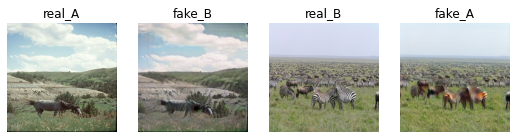

Epoch - 181
TRAIN - loss_G: 4.1437, loss_G_identity: 0.1931, loss_G_GAN: 0.8478, loss_G_cycle: 0.2330, loss_D: 0.3667
TEST -  loss_G: 4.7837, loss_G_identity: 0.2104, loss_G_GAN: 1.2124, loss_G_cycle: 0.2519, loss_D: 0.4329
Epoch - 182
TRAIN - loss_G: 4.0673, loss_G_identity: 0.1898, loss_G_GAN: 0.8326, loss_G_cycle: 0.2285, loss_D: 0.3582
TEST -  loss_G: 4.7023, loss_G_identity: 0.2193, loss_G_GAN: 0.9461, loss_G_cycle: 0.2659, loss_D: 0.3636
Epoch - 183
TRAIN - loss_G: 4.1969, loss_G_identity: 0.1955, loss_G_GAN: 0.8844, loss_G_cycle: 0.2335, loss_D: 0.3248
TEST -  loss_G: 4.5727, loss_G_identity: 0.2178, loss_G_GAN: 0.8832, loss_G_cycle: 0.2600, loss_D: 0.3884
Epoch - 184
TRAIN - loss_G: 4.1553, loss_G_identity: 0.1917, loss_G_GAN: 0.8952, loss_G_cycle: 0.2302, loss_D: 0.3588
TEST -  loss_G: 4.7286, loss_G_identity: 0.2215, loss_G_GAN: 0.9018, loss_G_cycle: 0.2719, loss_D: 0.4383
Epoch - 185
TRAIN - loss_G: 4.0620, loss_G_identity: 0.1915, loss_G_GAN: 0.8183, loss_G_cycle: 0.2286, l

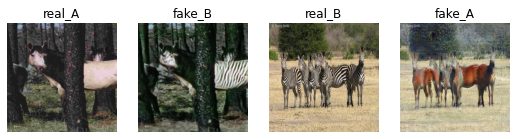

Epoch - 191
TRAIN - loss_G: 4.0505, loss_G_identity: 0.1879, loss_G_GAN: 0.8612, loss_G_cycle: 0.2250, loss_D: 0.3454
TEST -  loss_G: 5.3983, loss_G_identity: 0.2358, loss_G_GAN: 0.8251, loss_G_cycle: 0.3394, loss_D: 0.4278
Epoch - 192
TRAIN - loss_G: 4.1731, loss_G_identity: 0.1911, loss_G_GAN: 0.8824, loss_G_cycle: 0.2335, loss_D: 0.3383
TEST -  loss_G: 4.6423, loss_G_identity: 0.2215, loss_G_GAN: 0.9866, loss_G_cycle: 0.2548, loss_D: 0.4451
Epoch - 193
TRAIN - loss_G: 4.1745, loss_G_identity: 0.1930, loss_G_GAN: 0.8530, loss_G_cycle: 0.2357, loss_D: 0.3332
TEST -  loss_G: 4.4058, loss_G_identity: 0.2238, loss_G_GAN: 0.6783, loss_G_cycle: 0.2608, loss_D: 0.5111
Epoch - 194
TRAIN - loss_G: 4.1721, loss_G_identity: 0.1922, loss_G_GAN: 0.8406, loss_G_cycle: 0.2370, loss_D: 0.3495
TEST -  loss_G: 4.6263, loss_G_identity: 0.2121, loss_G_GAN: 1.0483, loss_G_cycle: 0.2517, loss_D: 0.5325
Epoch - 195
TRAIN - loss_G: 4.1114, loss_G_identity: 0.1889, loss_G_GAN: 0.8984, loss_G_cycle: 0.2269, l

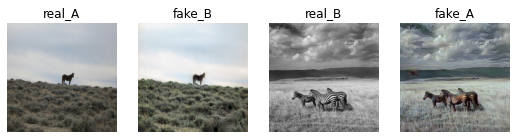

CPU times: user 2h 28min 7s, sys: 1h 46min 52s, total: 4h 15min
Wall time: 4h 39min 11s


In [20]:
%%time
train_loop(from_checkpoint=True)

### Losses
Посмотрим, как выглядят трейн и тест лоссы на обучении

In [21]:
logs = {}
for mode in ["train", "test"]:
    with open(f"output/{mode}_log.json", "r") as file:
        logs[mode] = json.load(file)

In [22]:
def plot_logs(train_log: dict, test_log: dict):
    for loss_name in train_log:
        plt.style.use('ggplot')
        plt.figure(figsize=(9, 6))
        plt.plot(train_log[loss_name], label="train")
        plt.plot(test_log[loss_name], label="test")
        plt.title(loss_name)
        plt.legend()
        plt.show()

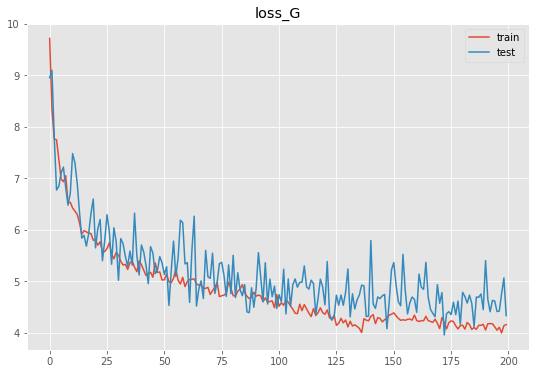

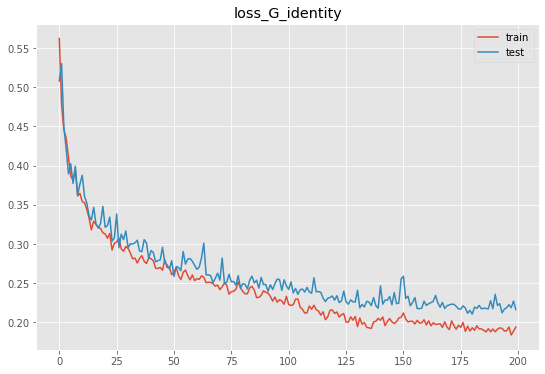

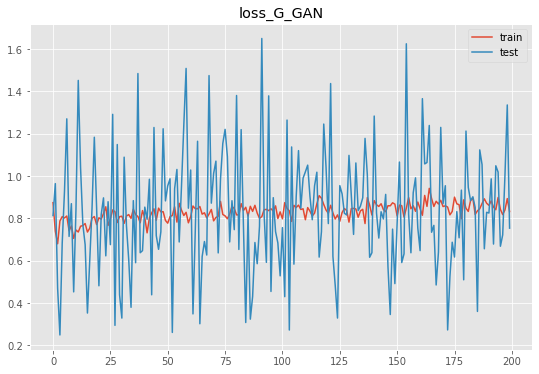

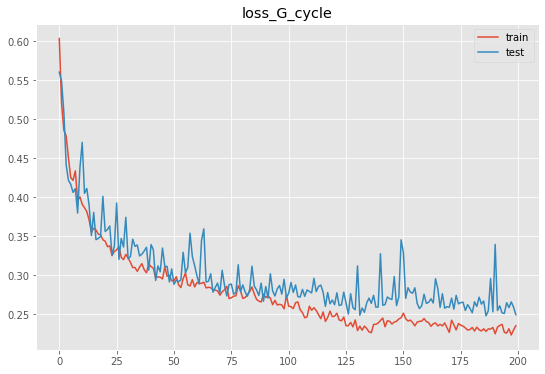

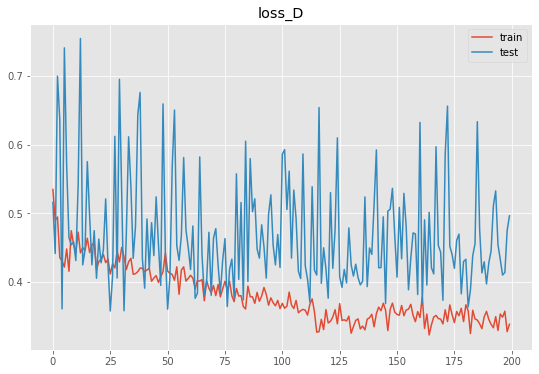

In [23]:
plot_logs(logs["train"], logs["test"])

## <center>Применение (тестирование) обученных и сохраненных генераторов

инициализация параметров для теста

In [9]:
# test params init
batchSize = 1  # size of the batches
dataroot = f'datasets/{dataset_name}/'  # root directory of the dataset
input_nc = 3  # number of channels of input data
output_nc = 3  # number of channels of output data
n_cpu = 8  # number of cpu threads to use during batch generation
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

инициализация моделей генераторов и загрузчика данных

In [10]:
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)

netG_A2B_path = 'output/best/netG_A2B.pth'
netG_B2A_path = 'output/best/netG_B2A.pth'

# load state dicts
netG_A2B.load_state_dict(torch.load(netG_A2B_path, map_location=device))
netG_B2A.load_state_dict(torch.load(netG_B2A_path, map_location=device))

# set test mode
netG_A2B.eval()
netG_B2A.eval()

# Dataset loader
test_transforms = [transforms.ToTensor(),
                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
test_dataloader = DataLoader(ImageDataset(dataroot, transforms_=test_transforms, mode='test'), 
                        batch_size=batchSize, shuffle=False, num_workers=n_cpu)

применяем генераторы к тестовой выборке и сохраняем результат (вместе с оригиналами)

In [26]:
# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, batch in enumerate(test_dataloader):
    # Set model input
    real_A = batch['A']
    real_B = batch['B']

    real_A_img = 0.5* (real_A.data + 1.0)
    real_B_img = 0.5* (real_B.data + 1.0)
    
    # Generate output
    fake_A2B_img = 0.5*(netG_A2B(real_A.to(device)).data + 1.0)
    fake_B2A_img = 0.5*(netG_B2A(real_B.to(device)).data + 1.0)

    # Save image files
    save_image(real_A_img, f'output/A/{i}_realA.png')
    save_image(real_B_img, f'output/B/{i}_realB.png')
    save_image(fake_A2B_img, f'output/A/{i}_fakeA2B.png')
    save_image(fake_B2A_img, f'output/B/{i}_fakeB2A.png')

## Визуализация результата

In [11]:
class PlotResult:
    def __init__(self, mode="A2B", root="output"):
        self.root = root
        self.mode = mode

    def plot(self, num=4, figsize=(24, 12)):
        real_liter = self.mode[0]
        self.real_files = sorted(glob.glob(os.path.join(self.root, real_liter, f'*_real{real_liter}.png')))
        self.fake_files = sorted(glob.glob(os.path.join(self.root, real_liter, f'*_fake{self.mode}.png')))

        inds = random.choices(list(range(len(self.real_files))), k=num)

        plt.figure(figsize=figsize)
        for i, ind in enumerate(inds):
            plt.subplot(2, num, i+1)
            plt.axis("off")
            plt.imshow(Image.open(self.real_files[ind]))
            plt.title(f"real{real_liter}")

            plt.subplot(2, num, num+i+1)
            plt.axis("off")
            plt.imshow(Image.open(self.fake_files[ind]))
            plt.title(f"fake{self.mode}")
        plt.show()

Визуализация результата **A2B**   
(несколько случайных вариантов)

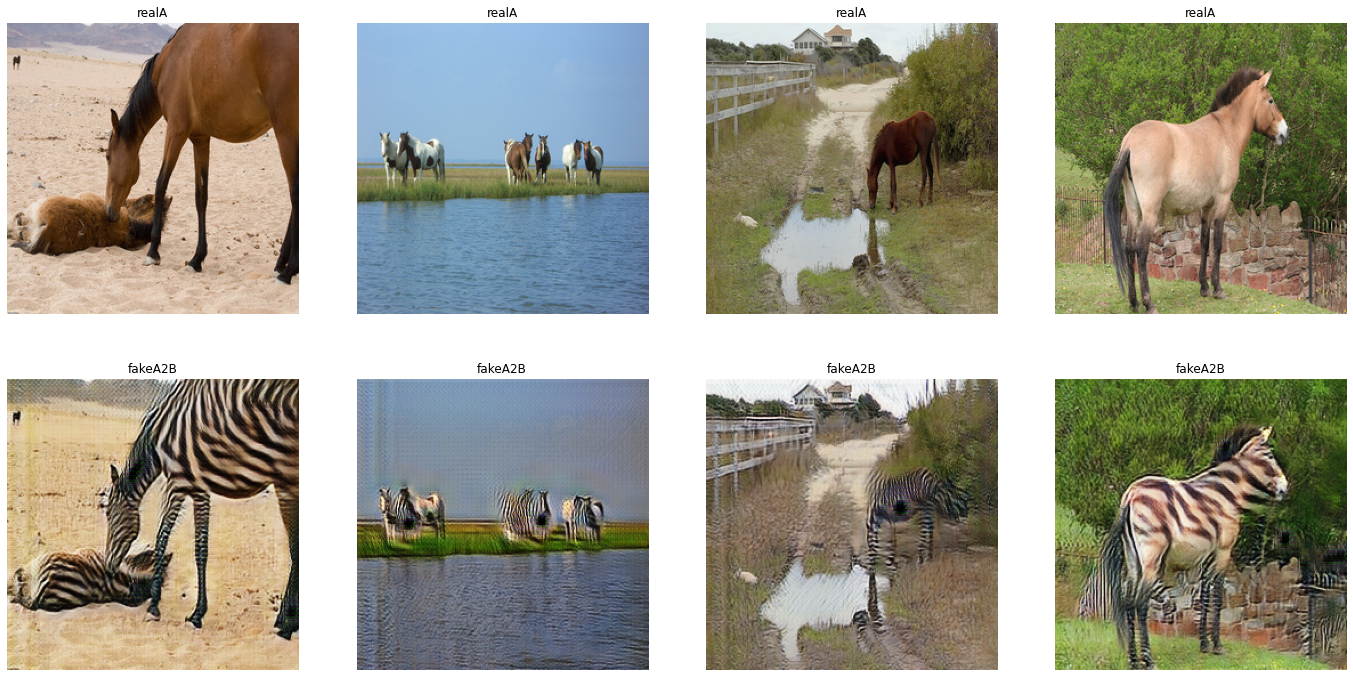

In [30]:
PlotResult("A2B").plot()

Визуализация результата **B2A**   
(несколько случайных вариантов)

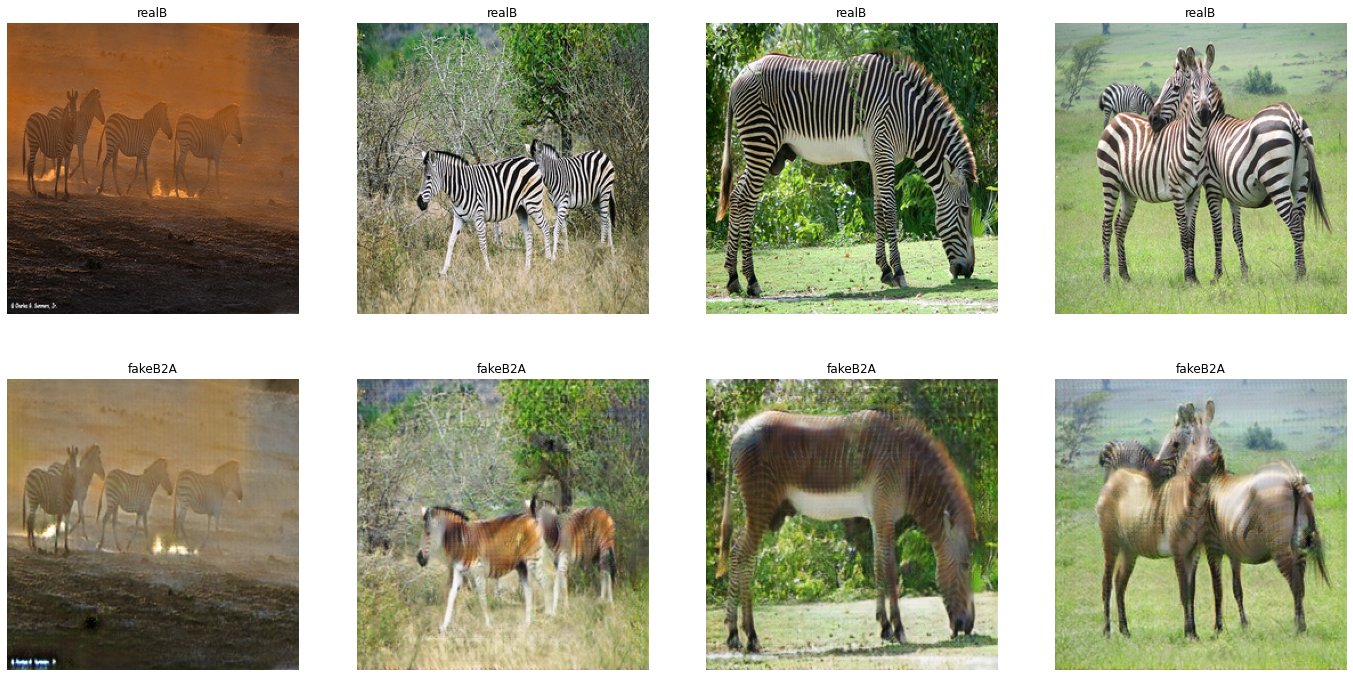

In [14]:
PlotResult("B2A").plot()

## Некоторые выводы
- В целом видно, что генераторы изображений работают
- Из лошади в зебру работает немного лучше, чем наоборот
- Обучение шло около 20 часов в 2 этапа (с восстановлением из чекпоинта), поскольку колаб не позволяет без прерывания работать более 12 часов
- В выборке около 1300 изображений каждого вида. В каждой эпохе пришлось использовать по 300 рандомных изображений, иначе обучение могло растянуться на несколько дней. Это затруднительная история, в том числе и из-за ограничений бесплатного колаба. 
- Могу предположить, что при более объемном обучении результат улучшился бы, поскольку переобучения на графиках лоссов пока не наблюдается
- Также пробовал делать обучения на датасете Моне-фото. Аналогично как и здесь, преобразование в одну сторону (Моне->фото) выглядит лучше, чем в другую. Думаю, это можно попробовать исправить весами при локальных лоссах в общем лоссе   